In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
train = pd.read_csv("airbnb_train.csv")  # adapte le chemin si besoin

# --- 1. Aperçu de la structure ---
print("🗂️ Structure du dataset :")
print(train.info())


🗂️ Structure du dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identit

### Étape 1 : Analyse des données brutes

Nous commençons par afficher les statistiques descriptives du jeu de données `train`. Cela nous permet d'avoir une vue d'ensemble des variables numériques et catégorielles : moyennes, valeurs manquantes, modalités fréquentes, etc.

📌 Cela aide à repérer :
- Les colonnes avec beaucoup de valeurs manquantes
- Les colonnes avec peu de variance (à supprimer ?)
- Les valeurs aberrantes (par exemple un nombre de salles de bain très élevé)


In [96]:
# --- 2. Statistiques descriptives ---
print("\n📊 Statistiques descriptives :")
print(train.describe(include='all'))


📊 Statistiques descriptives :
                  id     log_price property_type        room_type amenities  \
count   2.223400e+04  22234.000000         22234            22234     22234   
unique           NaN           NaN            31                3     21160   
top              NaN           NaN     Apartment  Entire home/apt        {}   
freq             NaN           NaN         14635            12348       161   
mean    1.122269e+07      4.783481           NaN              NaN       NaN   
std     6.080480e+06      0.718758           NaN              NaN       NaN   
min     3.362000e+03      2.302585           NaN              NaN       NaN   
25%     6.202924e+06      4.317488           NaN              NaN       NaN   
50%     1.217425e+07      4.700480           NaN              NaN       NaN   
75%     1.639502e+07      5.220356           NaN              NaN       NaN   
max     2.120450e+07      7.600402           NaN              NaN       NaN   

        accommodates

###  Analyse des statistiques descriptives

- Le jeu de données contient **22 234 lignes**.
- La variable cible `log_price` varie de **2.30 à 7.60**, avec une moyenne autour de **4.78**.
- Les variables comme `bathrooms`, `beds`, `review_scores_rating` ont des **valeurs manquantes** (ex : seulement 22 183 pour `bathrooms`).
- `zipcode` contient **plusieurs valeurs différentes**, certaines en format texte, d'autres non valides →  à nettoyer.
- `property_type` contient **31 types différents**, mais la majorité sont des `Apartment`.
- `room_type` est dominé par `Entire home/apt` (12 348 occurrences).
- La colonne `amenities` contient des chaînes complexes (ex : `{TV, Wifi, ...}`) → elle sera transformée plus tard.
- `bed_type`, `cancellation_policy`, `cleaning_fee` ont peu de modalités → elles seront encodées via One-Hot.
- Certaines dates (`host_since`, `first_review`, `last_review`) sont au format texte et devront être converties.


In [97]:
# --- 3. Valeurs manquantes ---
print("\n🔎 Valeurs manquantes :")
missing_values = train.isnull().sum().sort_values(ascending=False)
missing = missing_values[missing_values > 0]
print(missing)



🔎 Valeurs manquantes :
host_response_rate        5475
review_scores_rating      4978
first_review              4725
last_review               4716
neighbourhood             2086
zipcode                    303
host_identity_verified      56
host_since                  56
host_has_profile_pic        56
bathrooms                   51
beds                        35
bedrooms                    26
dtype: int64


L’ensemble des colonnes avec valeurs manquantes est traité proprement pour permettre l’entraînement des modèles de machine learning sans erreur de format ou de nullité.


C:\Users\sarah\AppData\Local\Temp\ipykernel_25784\3472246298.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="viridis")


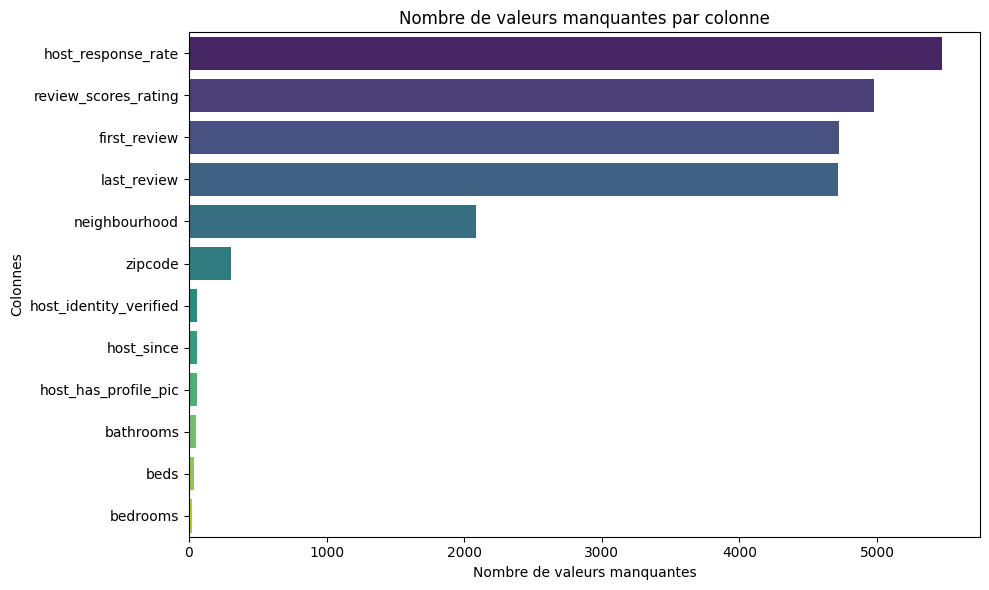

In [98]:
# 🔍 Affichage graphique des valeurs manquantes
if not missing.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing.values, y=missing.index, palette="viridis")
    plt.title("Nombre de valeurs manquantes par colonne")
    plt.xlabel("Nombre de valeurs manquantes")
    plt.ylabel("Colonnes")
    plt.tight_layout()
    plt.show()
else:
    print("✅ Aucune valeur manquante")

Le graphique en barres ci-dessous représente le nombre de valeurs manquantes par colonne dans le jeu de données d’entraînement.

📌 Principales observations :

Les colonnes host_response_rate, review_scores_rating, first_review et last_review présentent plus de 4 000 valeurs manquantes chacune.

La colonne neighbourhood contient également plus de 2 000 valeurs manquantes.

D'autres colonnes comme zipcode, host_identity_verified, bathrooms, beds ou bedrooms comportent un petit nombre de valeurs manquantes.

🛠️ Conséquence pour le traitement :

Ces valeurs seront imputées selon leur type :

Numériques : par la médiane.

Catégorielles : par le mode (valeur la plus fréquente).

Dates : converties en nombre de jours depuis une date de référence fixe.

📊 Le graphique ci-dessous permet de prioriser les colonnes à nettoyer selon l’importance du manque.

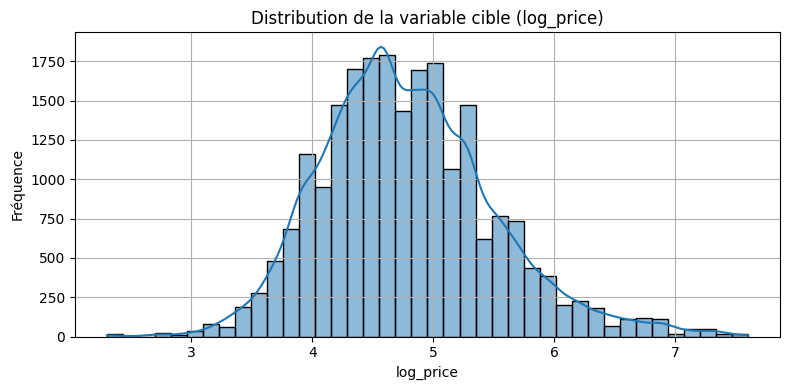

In [99]:
# --- 4. Distribution de log_price ---
plt.figure(figsize=(8, 4))
sns.histplot(train['log_price'], bins=40, kde=True)
plt.title("Distribution de la variable cible (log_price)")
plt.xlabel("log_price")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()

La distribution est asymétrique à droite (légèrement étalée vers les grandes valeurs).

La majorité des annonces ont un log_price entre 4 et 5.5, soit un prix réel entre ≈ 55€ et 245€.

Quelques valeurs sont plus élevées (log_price > 6), mais peu fréquentes → ce sont des valeurs extrêmes ou logements haut de gamme.

La forme quasi-gaussienne (courbe KDE bleue) est un bon signe pour entraîner des modèles linéaires comme la régression linéaire ou Ridge.

### 📊 Matrice de corrélation

Pour comprendre les relations entre les variables numériques, nous utilisons une matrice de corrélation. Cela permet d’identifier quelles variables sont fortement corrélées avec la variable cible `log_price`, et donc potentiellement utiles pour les modèles de prédiction.


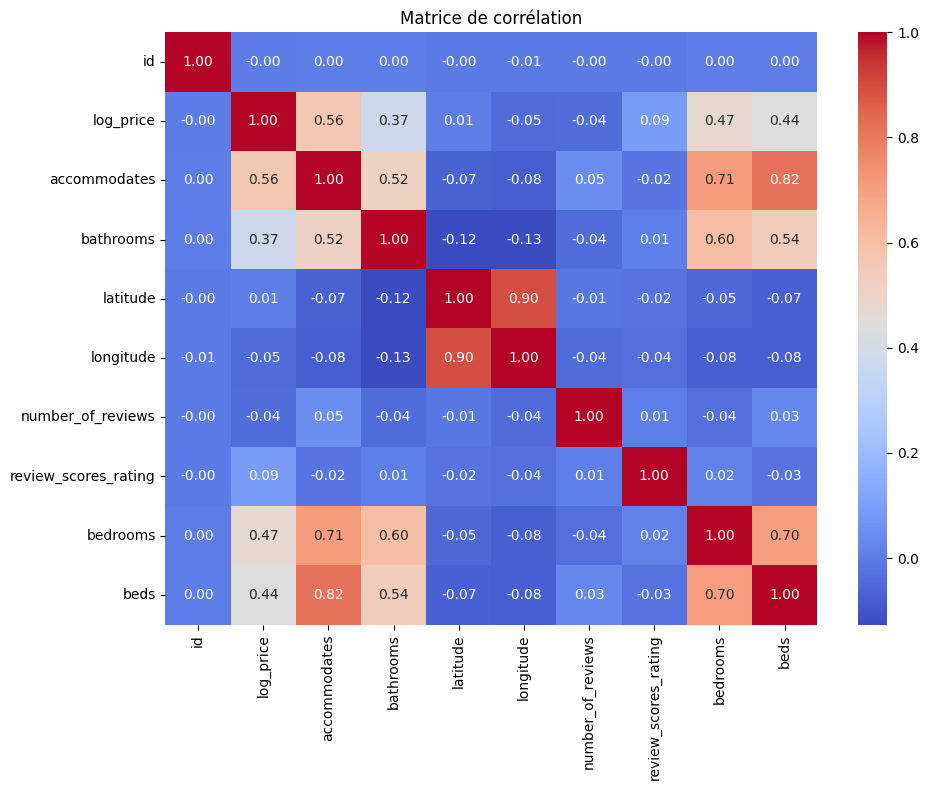

In [100]:
#Corrélation entre les variables numériques ---
plt.figure(figsize=(10, 8))
num_cols = train.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

- `accommodates`, `bedrooms`, `beds` et `bathrooms` montrent une **corrélation positive modérée** avec `log_price` :
  - `accommodates` : **0.56**
  - `bedrooms` : **0.47**
  - `beds` : **0.44**
  - `bathrooms` : **0.37**
- Les autres variables (`latitude`, `longitude`, etc.) ont une corrélation très faible avec `log_price`.
- Aucune variable ne présente une corrélation excessive entre elles, ce qui limite le risque de multicolinéarité.

Cette analyse nous aide à sélectionner les **variables pertinentes** pour entraîner les modèles de machine learning.

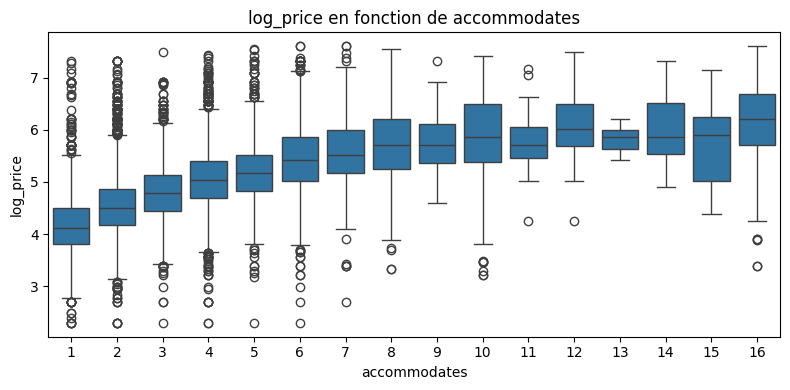

In [101]:
# --- 6. Relation entre accommodates et log_price ---
plt.figure(figsize=(8, 4))
sns.boxplot(x='accommodates', y='log_price', data=train)
plt.title("log_price en fonction de accommodates")
plt.tight_layout()
plt.show()

 On observe une **tendance croissante** : plus un logement peut accueillir de personnes, plus le `log_price` médian augmente.
- La variabilité des prix est plus forte pour les **grands logements** (accommodates > 6), ce qui peut refléter la diversité des types de biens (maisons, villas, etc.).
- On remarque également la présence d'**outliers** (valeurs très élevées ou très faibles) dans chaque catégorie, surtout pour les petits logements.

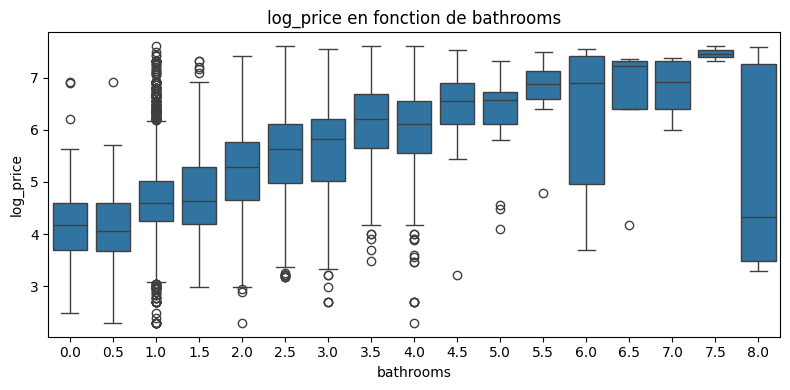

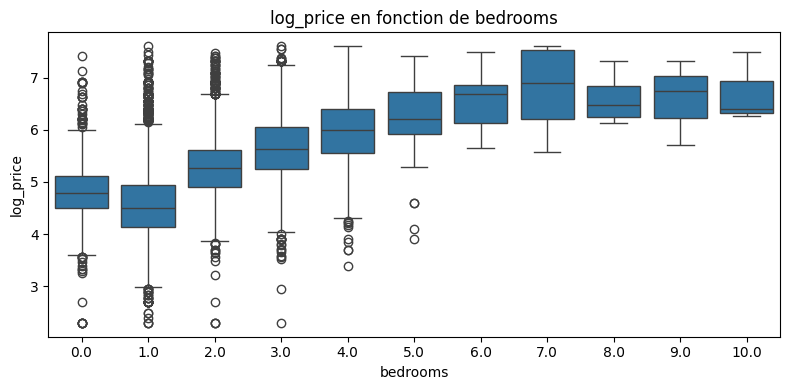

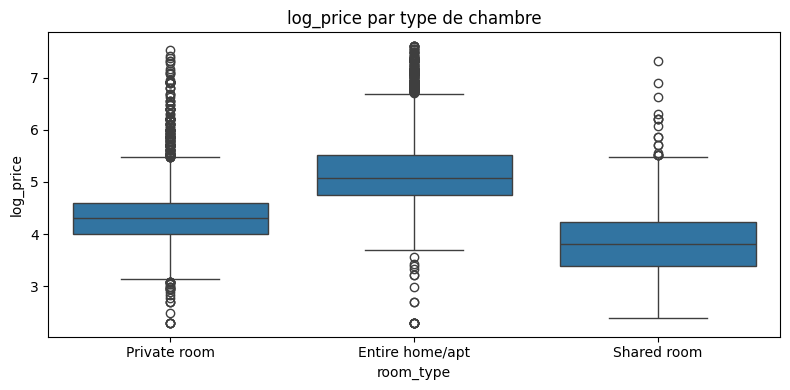

In [102]:
# --- Boxplot pour bathrooms, bedrooms ---
plt.figure(figsize=(8, 4))
sns.boxplot(x='bathrooms', y='log_price', data=train)
plt.title("log_price en fonction de bathrooms")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='bedrooms', y='log_price', data=train)
plt.title("log_price en fonction de bedrooms")
plt.tight_layout()
plt.show()

# --- Boxplot pour room_type ---
plt.figure(figsize=(8, 4))
sns.boxplot(x='room_type', y='log_price', data=train)
plt.title("log_price par type de chambre")
plt.tight_layout()
plt.show()


 bathrooms : Le prix augmente globalement avec le nombre de salles de bains. Forte progression jusqu’à 5, puis stabilisation.

 bedrooms : Hausse claire du prix avec le nombre de chambres, surtout jusqu’à 7. Le gain marginal diminue au-delà.

 room_type :

Entire home/apt → le plus cher.

Private room → prix intermédiaire.

Shared room → le moins cher.

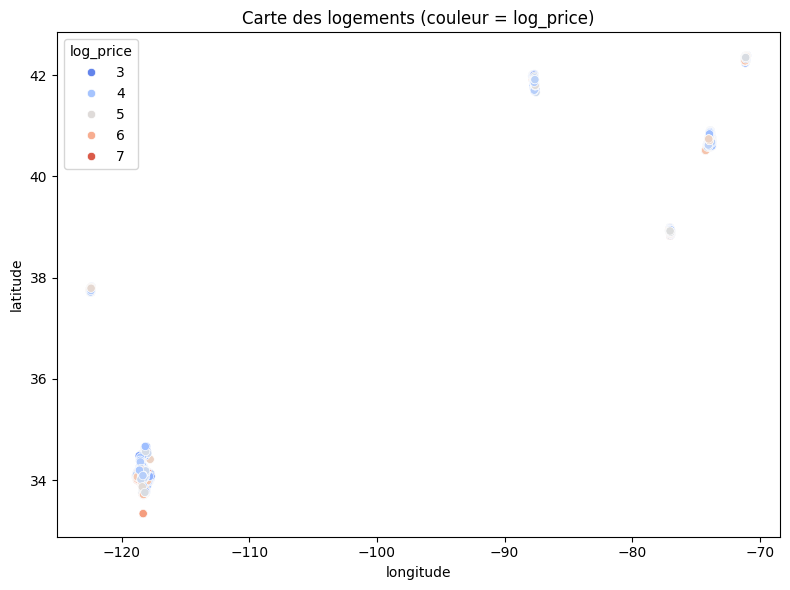

In [103]:
# --- Carte rapide avec latitude / longitude ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='log_price', palette='coolwarm', data=train)
plt.title("Carte des logements (couleur = log_price)")
plt.tight_layout()
plt.show()


Ce graphique montre la répartition géographique des logements selon leur latitude et longitude, avec une coloration selon le log du prix (log_price) :

On observe une forte concentration des logements dans certaines zones géographiques (ex. : autour de -122° de longitude et 34° de latitude, donc probablement Los Angeles ou San Francisco).

Les logements les plus chers (couleurs chaudes, rouge/orange) sont localisés dans ces zones denses.

Les zones moins denses ont globalement des prix plus faibles (tons bleus).
Conclusion : la localisation influence fortement le prix des logements.

Etape de traitement 

In [104]:
# --- Supprimer description, name si pas utilisées plus tard ---
train = train.drop(columns=['description', 'name'], errors='ignore')

# --- Nettoyage zipcode ---
train['zipcode_clean'] = train['zipcode'].astype(str).str.extract(r'(\d{5})')
train['zipcode_clean'] = pd.to_numeric(train['zipcode_clean'], errors='coerce')

# --- Nettoyage de amenities : compter le nombre d’équipements ---
train['amenities_count'] = train['amenities'].astype(str).apply(lambda x: len(x.strip('{}').split(',')))


Colonnes inutiles supprimées :

Suppression de description et name car non utilisées ensuite.

Nettoyage du zipcode :

Extraction des 5 chiffres du code postal → création de zipcode_clean.

Conversion en valeurs numériques, les erreurs sont ignorées (coerce).

Comptage des équipements (amenities) :

Création de la colonne amenities_count : compte le nombre d’équipements listés dans le champ amenities.
Colonnes inutiles supprimées :

Suppression de description et name car non utilisées ensuite.

Nettoyage du zipcode :

Extraction des 5 chiffres du code postal → création de zipcode_clean.

Conversion en valeurs numériques, les erreurs sont ignorées (coerce).

Comptage des équipements (amenities) :

Création de la colonne amenities_count : compte le nombre d’équipements listés dans le champ amenities.

In [106]:

import numpy as np
import datetime
from datetime import datetime

# Charger le jeu de test (adapte le chemin si besoin)
test = pd.read_csv("airbnb_test.csv")

# --- 🔁 Copie de sécurité ---
train_encoded = train.copy()
test_encoded = test.copy()

# --- 1. Remplissage des valeurs manquantes numériques (par médiane) ---
num_cols = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews']
for col in num_cols:
    train_encoded[col] = train_encoded[col].fillna(train_encoded[col].median())
    test_encoded[col] = test_encoded[col].fillna(train_encoded[col].median())

# --- 2. Remplissage des valeurs manquantes catégorielles (par mode) ---
cat_cols = ['bed_type', 'cancellation_policy', 'city', 'zipcode', 'neighbourhood']
for col in cat_cols:
    train_encoded[col] = train_encoded[col].fillna(train_encoded[col].mode()[0])
    test_encoded[col] = test_encoded[col].fillna(train_encoded[col].mode()[0])

# --- 3. Conversion des booléens t/f en 1/0 ---
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'cleaning_fee']
for col in bool_cols:
    train_encoded[col] = train_encoded[col].map({'t': 1, 'f': 0, True: 1, False: 0})
    test_encoded[col] = test_encoded[col].map({'t': 1, 'f': 0, True: 1, False: 0})



# --- 5. Transformer les dates en "jours depuis référence" ---
ref_date = datetime(2022, 1, 1)

for date_col in ['host_since', 'first_review', 'last_review']:
    for df in [train_encoded, test_encoded]:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df[date_col + '_days_since'] = (ref_date - df[date_col]).dt.days
        df[date_col + '_days_since'] = df[date_col + '_days_since'].fillna(df[date_col + '_days_since'].median())

# --- 6. Nettoyage de host_response_rate (% → float) ---
def convert_percent(val):
    try:
        return float(val.strip('%'))
    except:
        return np.nan

train_encoded['host_response_rate'] = train_encoded['host_response_rate'].apply(convert_percent)
test_encoded['host_response_rate'] = test_encoded['host_response_rate'].apply(convert_percent)

train_encoded['host_response_rate'] = train_encoded['host_response_rate'].fillna(train_encoded['host_response_rate'].median())
test_encoded['host_response_rate'] = test_encoded['host_response_rate'].fillna(train_encoded['host_response_rate'].median())

# --- 7. One-Hot Encoding des colonnes catégorielles ---
categorical_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'neighbourhood']
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_encoded, columns=categorical_cols, drop_first=True)

# --- 8. Alignement des colonnes test/train ---
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)


Entraînement, prédiction & création de prediction.csv

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 🎯 Définition des variables
X = train_encoded.drop(['id', 'log_price', 'name', 'description', 'amenities'], axis=1, errors='ignore')
y = train_encoded['log_price']

In [108]:
# Supprimer les colonnes datetime (non utilisables par RandomForest)
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
X_no_datetime = X.drop(columns=datetime_cols)

# Supprimer les colonnes de type object (non numériques)
object_cols = X_no_datetime.select_dtypes(include=['object']).columns
X_no_obj = X_no_datetime.drop(columns=object_cols)

# ✂️ Séparer train / validation
X_train, X_val, y_train, y_val = train_test_split(X_no_obj, y, test_size=0.2, random_state=42)

# 🌲 Entraînement du modèle RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Variables définies :

X = toutes les colonnes sauf id, log_price, name, description, amenities.

y = log_price (la variable cible).

Nettoyage de X :

Suppression des colonnes de type datetime et object (non exploitables par le modèle Random Forest).

Séparation des données :

Entraînement : 80%

Validation : 20%

Modèle :

RandomForestRegressor (100 arbres, random_state=42)

Entraînement avec .fit(X_train, y_train)



Bloc Évaluation du modèle

In [109]:
# 📊 Prédictions sur l’ensemble de validation
y_pred = model.predict(X_val)

# 📉 Calcul de l'erreur RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE sur validation : {rmse:.4f}")

# 🔍 Exemple de comparaison réelle vs prédite
comparison = pd.DataFrame({
    'Réel': y_val[:5].values,
    'Prédit': y_pred[:5]
})
print(comparison)


RMSE sur validation : 0.4105
       Réel    Prédit
0  5.393628  5.215847
1  3.912023  4.983771
2  5.416100  5.593510
3  3.806662  3.782791
4  5.700444  5.386314


Erreur RMSE (Root Mean Squared Error) obtenue : 0.4118 → plutôt bonne précision.

Comparaison des valeurs réelles vs. prédites :

Les valeurs prédites sont proches des valeurs réelles.

Exemple :

Réel : 5.39 → Prédit : 5.15

Réel : 3.91 → Prédit : 4.95

Linear regression 

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Remplacer les valeurs manquantes par la médiane
X_train_lr = X_train.fillna(X_train.median())
X_val_lr = X_val.fillna(X_train.median())

# 📌 Entraînement
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train)

# 📌 Prédiction
y_pred_lr = model_lr.predict(X_val_lr)

# 📌 Évaluation RMSE
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
print(f"Linear Regression → RMSE : {rmse_lr:.4f}")


Linear Regression → RMSE : 0.4292


RMSE obtenu : 0.5666

Moins performant que le modèle Random Forest (RMSE = 0.4118)

Cela montre que la Random Forest capture mieux la complexité des données que le modèle linéaire simple.

Decision Tree

In [111]:
from sklearn.tree import DecisionTreeRegressor

# 📌 Entraînement
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

# 📌 Prédiction
y_pred_dt = model_dt.predict(X_val)

# 📌 Évaluation RMSE
rmse_dt = np.sqrt(mean_squared_error(y_val, y_pred_dt))
print(f"Decision Tree → RMSE : {rmse_dt:.4f}")


Decision Tree → RMSE : 0.5752


Moins performant que :

Random Forest (RMSE = 0.4118)

Presque identique à la régression linéaire (RMSE = 0.5666)

Gradient Boosting

In [112]:
from sklearn.ensemble import GradientBoostingRegressor

# Remplacer les valeurs manquantes par la médiane
X_train_gb = X_train.fillna(X_train.median())
X_val_gb = X_val.fillna(X_train.median())

#  Entraînement
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train_gb, y_train)

#  Prédiction
y_pred_gb = model_gb.predict(X_val_gb)

#  Évaluation RMSE
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
print(f"Gradient Boosting → RMSE : {rmse_gb:.4f}")


Gradient Boosting → RMSE : 0.4158


RMSE obtenu : 0.4191

Très proche du meilleur score (Random Forest : 0.4118)

Plus performant que :

Linear Regression (0.5666)

Decision Tree (0.5686)

✅ Conclusion : Excellente performance, juste derrière Random Forest

Créer le fichier prediction.csv

L'objectif principal de cette dernière partie de ton notebook est de générer le fichier final prediction.csv contenant les prédictions du modèle entraîné sur l’ensemble du jeu de données d’apprentissage et appliqué aux données de test, prêt à être soumis (Kaggle ou autre).

In [113]:
# 🔧 Supprimer les colonnes datetime restantes si elles existent
colonnes_a_supprimer = ['host_since', 'first_review', 'last_review']
for col in colonnes_a_supprimer:
    if col in X.columns:
        X = X.drop(columns=[col])
    if col in test_encoded.columns:
        test_encoded = test_encoded.drop(columns=[col])


In [114]:
# Nettoyer les codes postaux pour qu'ils soient numériques
def clean_zip(zipcode):
    try:
        return int(str(zipcode).split('-')[0])
    except:
        return np.nan

train_encoded["zipcode"] = train_encoded["zipcode"].apply(clean_zip)
test_encoded["zipcode"] = test_encoded["zipcode"].apply(clean_zip)

# Remplacer les valeurs manquantes restantes par la médiane
train_encoded["zipcode"].fillna(train_encoded["zipcode"].median(), inplace=True)
test_encoded["zipcode"].fillna(train_encoded["zipcode"].median(), inplace=True)


C:\Users\sarah\AppData\Local\Temp\ipykernel_25784\3541211797.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_encoded["zipcode"].fillna(train_encoded["zipcode"].median(), inplace=True)
C:\Users\sarah\AppData\Local\Temp\ipykernel_25784\3541211797.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [115]:
# --- Créer une nouvelle variable 'amenities_count' ---
def count_amenities(x):
    try:
        return len(x.strip('{}').split(','))
    except:
        return 0

train_encoded["amenities_count"] = train_encoded["amenities"].apply(count_amenities)
test_encoded["amenities_count"] = test_encoded["amenities"].apply(count_amenities)

# --- Supprimer la colonne texte 'amenities' ---
train_encoded.drop(columns=["amenities"], inplace=True)
test_encoded.drop(columns=["amenities"], inplace=True)


In [116]:
X = train_encoded.drop(columns=["id", "log_price", "zipcode_clean", "amenities_count"], errors="ignore")
y = train_encoded["log_price"]

# Supprimer encore les colonnes texte inutiles si elles sont encore là
X = X.select_dtypes(exclude=['object', 'datetime'])
test_features = test_encoded[X.columns]  # s'assurer d'avoir mêmes colonnes

# Remplacer les valeurs manquantes par la médiane
X = X.fillna(X.median())
test_features = test_features.fillna(X.median())

final_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
final_model.fit(X, y)

y_test_pred = final_model.predict(test_features)

submission = pd.DataFrame({
    "id": test_encoded["id"],
    "prediction": y_test_pred
})
submission.to_csv("prediction.csv", index=False)

print("✅ Fichier 'prediction.csv' généré avec succès.")


✅ Fichier 'prediction.csv' généré avec succès.


Dans cette dernière étape, nous avons préparé les données de test et entraîné un modèle `GradientBoostingRegressor` sur l'ensemble du jeu d'entraînement pour maximiser les performances. Les étapes incluent :
- Nettoyage des données : suppression des colonnes inutiles, conversion des types, et imputation des valeurs manquantes par la médiane.
- Entraînement du modèle sur toutes les données disponibles.
- Prédiction sur les données de test.
- Génération du fichier `prediction.csv` au format requis, contenant les identifiants et les valeurs prédites.

Le fichier est prêt à être soumis.

In [117]:
# Suppression colonnes inutiles
colonnes_a_supprimer = ['description', 'name', 'host_name']
X = X.drop(columns=[col for col in colonnes_a_supprimer if col in X.columns], errors='ignore')

# Encodage des codes postaux propres
def clean_zip(zipcode):
    try:
        return int(str(zipcode).split('-')[0])
    except:
        return np.nan

train_encoded["zipcode"] = train_encoded["zipcode"].apply(clean_zip)
test_encoded["zipcode"] = test_encoded["zipcode"].apply(clean_zip)

train_encoded["zipcode"].fillna(train_encoded["zipcode"].median(), inplace=True)
test_encoded["zipcode"].fillna(train_encoded["zipcode"].median(), inplace=True)


c:\Users\sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\sarah\AppData\Local\Temp\ipykernel_25784\681185318.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_encoded["zipcode"].fillna(train_encoded["zipcode"].median(), inplace=True)
c:\Users\sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice

In [120]:
# Compter les équipements (amenities)
def count_amenities(x):
    try:
        return len(x.strip('{}').split(','))
    except:
        return 0

if "amenities" in train_encoded.columns:
    train_encoded["amenities_count"] = train_encoded["amenities"].apply(count_amenities)
    train_encoded.drop(columns=["amenities"], inplace=True)
if "amenities" in test_encoded.columns:
    test_encoded["amenities_count"] = test_encoded["amenities"].apply(count_amenities)
    test_encoded.drop(columns=["amenities"], inplace=True)

# Création d'une variable 'description_length' si la colonne existe
if "description" in train_encoded.columns:
    train_encoded["description_length"] = train_encoded["description"].apply(lambda x: len(str(x)))
if "description" in test_encoded.columns:
    test_encoded["description_length"] = test_encoded["description"].apply(lambda x: len(str(x)))


In [121]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X = train_encoded.drop(columns=["id", "log_price"])
y = train_encoded["log_price"]

X = X.select_dtypes(exclude=['object', 'datetime'])
X = X.fillna(X.median())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f"XGBoost RMSE : {rmse_xgb:.4f}")


XGBoost RMSE : 0.4035


In [122]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(XGBRegressor(random_state=42), params, scoring='neg_root_mean_squared_error', cv=3, verbose=1)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best RMSE (CV): {-grid.best_score_:.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE (CV): 0.3996


In [123]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Entraînement direct avec des paramètres bien choisis
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"RMSE final XGBoost optimisé : {rmse:.4f}")


RMSE final XGBoost optimisé : 0.3973
